In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from data import *
from preprocessing import *
from feature_extraction import *
from train_and_test import *
from network import *
import matplotlib.pyplot as plt
import mne, scipy, random
%matplotlib inline

In [51]:
def determinize(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
seed = 42
determinize(42)

In [29]:
raw_segmented_data, segmented_dataframes = load_data()
raw_filtered_data, filtered_dataframes = load_data(subfolder='Filtered_Data')

Sampling frequency might not be 200 Hz, but 199.2 Hz for s03_ex06.csv
Sampling frequency might not be 200 Hz, but 368.03333333333336 Hz for s03_ex07.csv
Sampling frequency might not be 200 Hz, but 124.75833333333334 Hz for s20_ex01_s03.csv
Sampling frequency might not be 200 Hz, but 334.28333333333336 Hz for s05_ex05.csv
Sampling frequency might not be 200 Hz, but 194.63333333333333 Hz for s19_ex01_s03.csv
Sampling frequency might not be 200 Hz, but 234.08333333333334 Hz for s17_ex10.csv
Sampling frequency might not be 200 Hz, but 199.2 Hz for s03_ex06.csv
Sampling frequency might not be 200 Hz, but 368.03333333333336 Hz for s03_ex07.csv
Sampling frequency might not be 200 Hz, but 124.75833333333334 Hz for s20_ex01_s03.csv
Sampling frequency might not be 200 Hz, but 334.28333333333336 Hz for s05_ex05.csv
Sampling frequency might not be 200 Hz, but 194.63333333333333 Hz for s19_ex01_s03.csv
Sampling frequency might not be 200 Hz, but 234.08333333333334 Hz for s17_ex10.csv


## Reproducing the Filtering

According to the dataset creators, they applied a first order 1-40 Hz Butterworth filter and a 50 Hz notch filter with a quality factor of 30. We'll demonstrate the step by step filtering for the T7 channel over the segmented data to get data that resembles their filtered data.

In [30]:
s01_ex02_s01_segmented_df = segmented_dataframes[1][2][0]
s01_ex02_s01_segmented_raw = raw_segmented_data[1][2][0]
s01_ex02_s01_filtered_df = filtered_dataframes[1][2][0]
s01_ex02_s01_filtered_raw = raw_filtered_data[1][2][0]

### Plotting the power spectral density of the segmented data

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/7s/5h000n6s2z75cbf4y33k39y40000gn/T/ipykernel_85207/1175685742.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = s01_ex02_s01_segmented_raw.compute_psd(fmax=70, picks="T7").plot(picks="data", exclude="bads", amplitude=False)
/Users/syntactic/miniconda3/envs/dna/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


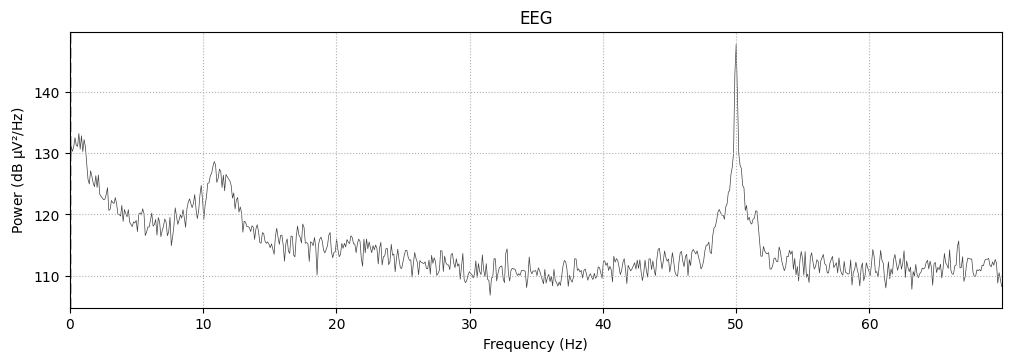

In [31]:
_ = s01_ex02_s01_segmented_raw.compute_psd(fmax=70, picks="T7").plot(picks="data", exclude="bads", amplitude=False)

### Plotting the power spectral density of the pre-filtered data

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/7s/5h000n6s2z75cbf4y33k39y40000gn/T/ipykernel_85207/1836852016.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = s01_ex02_s01_filtered_raw.compute_psd(fmax=70, picks="T7").plot(picks="data", exclude="bads", amplitude=False, show=False)


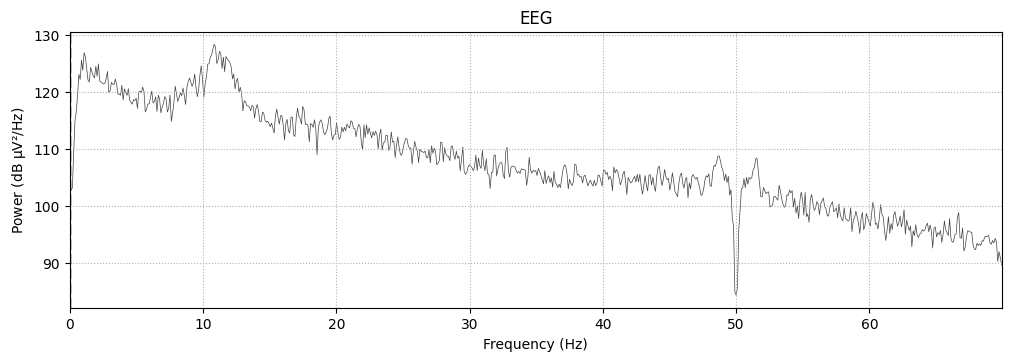

In [32]:
_ = s01_ex02_s01_filtered_raw.compute_psd(fmax=70, picks="T7").plot(picks="data", exclude="bads", amplitude=False, show=False)

#### Measuring Pearson correlation
As a distance measure, we can use the Pearson correlation coefficient to see how similar the unprocessed segmented data are compared to the filtered data. Below we see that it's **0.52**.

In [33]:
print(scipy.stats.pearsonr(s01_ex02_s01_segmented_df["T7"].values, s01_ex02_s01_filtered_df["T7"].values))

PearsonRResult(statistic=np.float64(0.5224437525082677), pvalue=np.float64(0.0))


### Applying the Butterworth 1-40 Hz filter
First, we'll apply the Butterworth bandpass filter to the data and measure the resulting data's correlation with the fully filtered data provided in the dataset. We see that it's **0.85**, which is higher than the previous 0.52.

In [34]:
b, a = butter_bandpass(lowcut=1, highcut=40, sampling_rate=200, order=1)
s01_ex02_s01_t7 = s01_ex02_s01_segmented_df[["T7"]]
filtered_t7 = apply_filter(b, a, s01_ex02_s01_t7["T7"])
s01_ex02_s01_t7.loc[:, "T7"] = filtered_t7
print(scipy.stats.pearsonr(s01_ex02_s01_t7["T7"].values, s01_ex02_s01_filtered_df["T7"].values))

PearsonRResult(statistic=np.float64(0.8544653598804924), pvalue=np.float64(0.0))


### Applying the notch filter to remove electric grid noise
Next, we'll apply the notch filter to the data and again measure the correlation. Now we see that it's correlation is **1.0**, which is what we were hoping for.

In [35]:
b, a = notch(freq=50, sampling_rate=200, quality_factor=30)
filtered_t7 = apply_filter(b, a, s01_ex02_s01_t7["T7"])
s01_ex02_s01_t7.loc[:, "T7"] = filtered_t7
print(scipy.stats.pearsonr(s01_ex02_s01_t7["T7"].values, s01_ex02_s01_filtered_df["T7"].values))

PearsonRResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))


### Plotting the power spectral density of the newly filtered data
We can plot the PSD of the data we just processed and find that its plot is identical to that of the plotted PSD of the data provided by the dataset creators.

Creating RawArray with float64 data, n_channels=1, n_times=24000
    Range : 0 ... 23999 =      0.000 ...   119.995 secs
Ready.
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/7s/5h000n6s2z75cbf4y33k39y40000gn/T/ipykernel_85207/32752297.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = s01_ex02_s01_t7_raw_array.compute_psd(fmax=70, picks="T7").plot(picks="data", exclude="bads", amplitude=False, show=False)


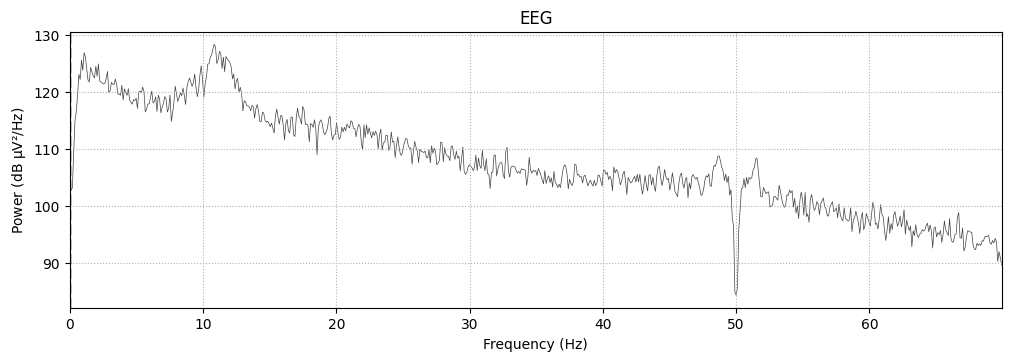

In [36]:
s01_ex02_s01_t7_info = mne.create_info(ch_names=["T7"], sfreq=200, ch_types="eeg")
s01_ex02_s01_t7_raw_array = mne.io.RawArray(s01_ex02_s01_t7.T7.values.reshape(1, -1), s01_ex02_s01_t7_info)
_ = s01_ex02_s01_t7_raw_array.compute_psd(fmax=70, picks="T7").plot(picks="data", exclude="bads", amplitude=False, show=False)

In [37]:
preprocessed_dataframe_dict = preprocess_dataframe_dict(segmented_dataframes)
preprocessed_dataframe_dict[1][2][0].head()

,T7,F8,Cz,P4
0,10.610456,7.252032,8.006351,7.708540
1,1.283587,-4.845430,-4.458679,-6.074812
2,-5.966711,-14.084743,-15.442003,-19.870071
3,2.277066,-8.586904,-12.123229,-18.701722
4,12.010765,0.161105,-5.292705,-11.880606


## Processing the resting state eyes closed data
Using a helper function, we can create a dictionary for each subject, containing all the resting state eyes closed sessions (three per subject).

In [38]:
subject_experiment_2_dict = create_subject_experiment_data_dict(preprocessed_dataframe_dict, experiment_id=2)
print(f"Number of subjects: {len(subject_experiment_2_dict)}")
print(f"Number of sessions for subject 1: {len(subject_experiment_2_dict[1])}")
print(f"Number of samples for subject 1 session 1: {len(subject_experiment_2_dict[1][1])}")

Number of subjects: 20
Number of sessions for subject 1: 3
Number of samples for subject 1 session 1: 24000


### Epoching the data
Since each segmented session is two minutes long, we can split these up into epochs of four seconds each, as did the authors of the paper. This means that we should end up with 30 epochs of 800 samples per session.

In [39]:
epoched_subject_experiment_2_dict = epoch_subject_experiment_data_dict(subject_experiment_2_dict)
print(f"Number of subjects: {len(epoched_subject_experiment_2_dict)}")
print(f"Number of epochs for subject 1: {len(epoched_subject_experiment_2_dict[1])}")
print(f"Number of samples for subject 1 epoch 1: {len(epoched_subject_experiment_2_dict[1][1])}")

Number of subjects: 20
Number of epochs for subject 1: 90
Number of samples for subject 1 epoch 1: 800


/Users/syntactic/miniconda3/envs/dna/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Extracting Features
Now we can reduce the dimensionality of each epoch by extracting features from them. We will take a subset of the features mentioned in the paper, adding up to 44 features per epoch:
* amplitude standard deviation
* amplitude standard deviation
* amplitude range
* amplitude kurtosis
* mean power spectral density for five bands (delta, theta, alpha, beta, gamma) for each of the four channels (20 features total)
* standard deviation of power spectral density for five bands (delta, theta, alpha, beta, gamma) for each of the four channels (20 features total)


In [40]:
eeg_dataset_experiment_2 = create_dataset_from_epoched_experiment_data_dict(epoched_subject_experiment_2_dict)
features, label = eeg_dataset_experiment_2[0]
num_features = len(features)
print(f"Number of samples: {len(eeg_dataset_experiment_2)}")
print(f"Number of features of first sample: {num_features}")
print(f"Subject ID of first sample: {label}")

Number of samples: 1800
Number of features of first sample: 48
Subject ID of first sample: 8


## Training and Testing

### Splitting Data into Training Set and Test Set

In [41]:
train_dataset, test_dataset = split_dataset(eeg_dataset_experiment_2, split_ratio=0.8)
train_dataloader = th.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = th.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

## Training
We'll initialize the multi-layer perceptron and then set up a cross entropy loss function and an Adam optimizer.

In [42]:
mlp = MLP(input_size=num_features)
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
num_epochs_experiment_2 = 1000

In [43]:
training_losses, testing_losses, experiment_2_testing_accuracies = train_and_test_model(mlp, train_dataloader, test_dataloader, optimizer, criterion, epochs=num_epochs_experiment_2)

Epoch: 0, Loss: 3.0459113121032715
Accuracy: 20.27777777777778
Epoch: 1, Loss: 2.7768003940582275
Accuracy: 23.61111111111111
Epoch: 2, Loss: 2.870882511138916
Accuracy: 28.333333333333332
Epoch: 3, Loss: 2.750826597213745
Accuracy: 28.888888888888886
Epoch: 4, Loss: 2.810405731201172
Accuracy: 33.88888888888889
Epoch: 5, Loss: 2.622692108154297
Accuracy: 34.72222222222222
Epoch: 6, Loss: 2.5234432220458984
Accuracy: 32.5
Epoch: 7, Loss: 2.600788116455078
Accuracy: 34.166666666666664
Epoch: 8, Loss: 2.636488437652588
Accuracy: 36.388888888888886
Epoch: 9, Loss: 2.6992344856262207
Accuracy: 35.0
Epoch: 10, Loss: 2.6100213527679443
Accuracy: 36.94444444444444
Epoch: 11, Loss: 2.6405014991760254
Accuracy: 35.833333333333336
Epoch: 12, Loss: 2.360502004623413
Accuracy: 37.5
Epoch: 13, Loss: 2.6909589767456055
Accuracy: 37.77777777777778
Epoch: 14, Loss: 2.649296522140503
Accuracy: 37.77777777777778
Epoch: 15, Loss: 2.6901726722717285
Accuracy: 37.77777777777778
Epoch: 16, Loss: 2.727154731

### Plotting Loss and Accuracy Curves

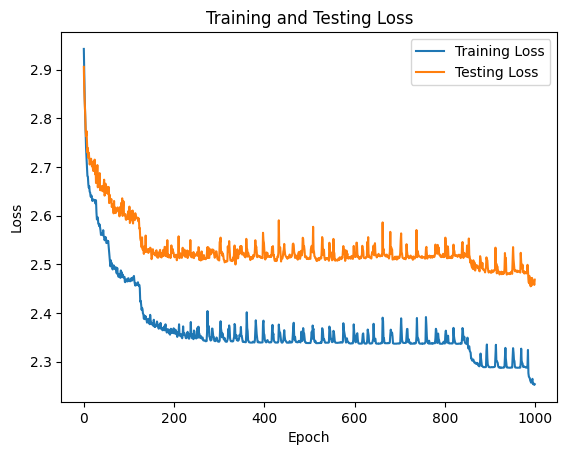

In [44]:
plt.clf()
plt.plot(training_losses)
plt.plot(testing_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()


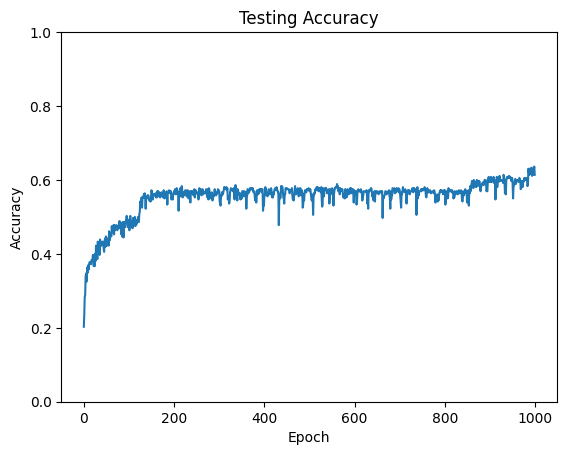

In [45]:
plt.plot(experiment_2_testing_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Testing Accuracy")
plt.show()

## Repeating the process for the data where subjects are listening to neutral music

In [46]:
subject_experiment_7_dict = create_subject_experiment_data_dict(preprocessed_dataframe_dict, experiment_id=7)
epoched_subject_experiment_7_dict = epoch_subject_experiment_data_dict(subject_experiment_7_dict)
eeg_dataset_experiment_7 = create_dataset_from_epoched_experiment_data_dict(epoched_subject_experiment_7_dict)
print(len(eeg_dataset_experiment_7))
# calculate the ratio of eeg_dataset_experiment_2 to eeg_dataset_experiment_7
fairness_ratio = len(eeg_dataset_experiment_2) / len(eeg_dataset_experiment_7)
train_dataset, test_dataset = split_dataset(eeg_dataset_experiment_7, split_ratio=0.8)


625


In [47]:
train_dataloader = th.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = th.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
mlp = MLP(input_size=num_features)
criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
num_epochs_experiment_7 = int(num_epochs_experiment_2 * fairness_ratio)
print(f"Training for {num_epochs_experiment_7} epochs to expose the model to the same amount of data")
training_losses, testing_losses, experiment_7_testing_accuracies = train_and_test_model(mlp, train_dataloader, test_dataloader, optimizer, criterion, epochs=num_epochs_experiment_7)

Training for 2880 epochs to expose the model to the same amount of data
Epoch: 0, Loss: 2.9801185131073
Accuracy: 16.8
Epoch: 1, Loss: 2.983354330062866
Accuracy: 14.399999999999999
Epoch: 2, Loss: 2.952359676361084
Accuracy: 15.2
Epoch: 3, Loss: 2.8947150707244873
Accuracy: 15.2
Epoch: 4, Loss: 2.9629759788513184
Accuracy: 15.2
Epoch: 5, Loss: 2.701890468597412
Accuracy: 18.4
Epoch: 6, Loss: 2.821850299835205
Accuracy: 21.6
Epoch: 7, Loss: 2.647742509841919
Accuracy: 20.8
Epoch: 8, Loss: 2.9516472816467285
Accuracy: 22.400000000000002
Epoch: 9, Loss: 2.838326930999756
Accuracy: 23.200000000000003
Epoch: 10, Loss: 2.8035569190979004
Accuracy: 24.0
Epoch: 11, Loss: 2.783810615539551
Accuracy: 24.0
Epoch: 12, Loss: 2.8084053993225098
Accuracy: 26.400000000000002
Epoch: 13, Loss: 2.7200584411621094
Accuracy: 24.8
Epoch: 14, Loss: 2.652599334716797
Accuracy: 26.400000000000002
Epoch: 15, Loss: 2.8633642196655273
Accuracy: 27.200000000000003
Epoch: 16, Loss: 2.5779426097869873
Accuracy: 27.

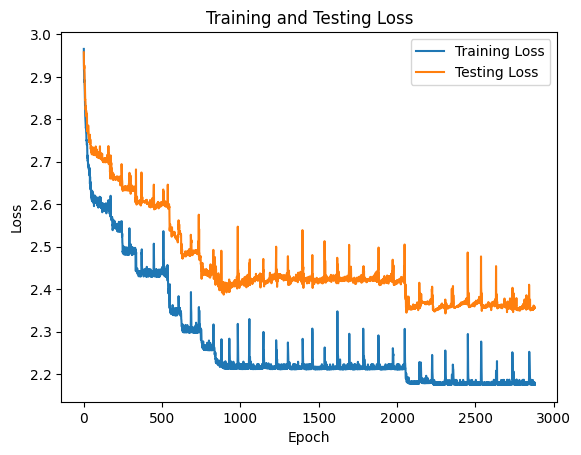

In [48]:
plt.plot(training_losses)
plt.plot(testing_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss")
plt.legend(["Training Loss", "Testing Loss"])
plt.show()

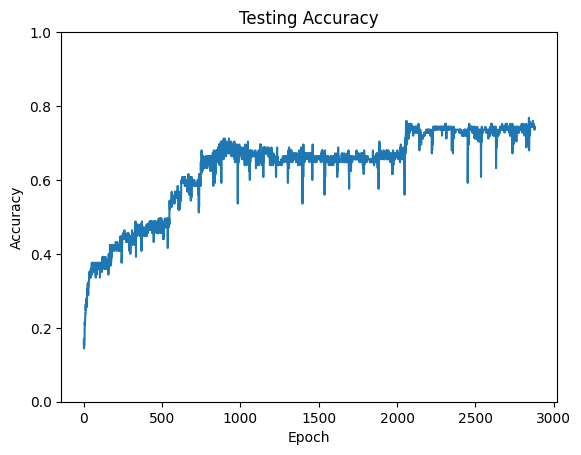

In [49]:
plt.plot(experiment_7_testing_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Testing Accuracy")
plt.show()

In [50]:
# average the accuracy of the last 100 epochs for both experiments
experiment_2_avg_accuracy = np.mean(experiment_2_testing_accuracies[int(num_epochs_experiment_2*-0.05):])
experiment_7_avg_accuracy = np.mean(experiment_7_testing_accuracies[int(num_epochs_experiment_7*-0.05):])

# calculate relative improvement
relative_improvement = (experiment_7_avg_accuracy - experiment_2_avg_accuracy) / experiment_2_avg_accuracy * 100

print(f"Experiment 2 Average Accuracy: {experiment_2_avg_accuracy}")
print(f"Experiment 7 Average Accuracy: {experiment_7_avg_accuracy}")
print(f"Relative Improvement: {relative_improvement}%")

Experiment 2 Average Accuracy: 0.6025
Experiment 7 Average Accuracy: 0.7367777777777776
Relative Improvement: 22.286768095896697%


In [52]:
seeds = list(range(42, 52))
experiment_2_accuracies = []
experiment_7_accuracies = []
relative_improvements = []
for seed in seeds:
    determinize(seed)
    preprocessed_dataframe_dict = preprocess_dataframe_dict(segmented_dataframes)
    subject_experiment_2_dict = create_subject_experiment_data_dict(preprocessed_dataframe_dict, experiment_id=2)
    epoched_subject_experiment_2_dict = epoch_subject_experiment_data_dict(subject_experiment_2_dict)
    eeg_dataset_experiment_2 = create_dataset_from_epoched_experiment_data_dict(epoched_subject_experiment_2_dict)
    train_dataset, test_dataset = split_dataset(eeg_dataset_experiment_2, split_ratio=0.8)
    train_dataloader = th.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = th.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
    mlp = MLP(input_size=num_features)
    criterion = th.nn.CrossEntropyLoss()
    optimizer = th.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
    num_epochs_experiment_2 = 1000
    training_losses, testing_losses, experiment_2_testing_accuracies = train_and_test_model(mlp, train_dataloader, test_dataloader, optimizer, criterion, epochs=num_epochs_experiment_2, verbose=False)
    subject_experiment_7_dict = create_subject_experiment_data_dict(preprocessed_dataframe_dict, experiment_id=7)
    epoched_subject_experiment_7_dict = epoch_subject_experiment_data_dict(subject_experiment_7_dict)
    eeg_dataset_experiment_7 = create_dataset_from_epoched_experiment_data_dict(epoched_subject_experiment_7_dict)
    fairness_ratio = len(eeg_dataset_experiment_2) / len(eeg_dataset_experiment_7)
    train_dataset, test_dataset = split_dataset(eeg_dataset_experiment_7, split_ratio=0.8)
    train_dataloader = th.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_dataloader = th.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
    mlp = MLP(input_size=num_features)
    criterion = th.nn.CrossEntropyLoss()
    optimizer = th.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
    num_epochs_experiment_7 = int(num_epochs_experiment_2 * fairness_ratio)
    training_losses, testing_losses, experiment_7_testing_accuracies = train_and_test_model(mlp, train_dataloader, test_dataloader, optimizer, criterion, epochs=num_epochs_experiment_7, verbose=False)
    experiment_2_avg_accuracy = np.mean(experiment_2_testing_accuracies[int(num_epochs_experiment_2*-0.05):])
    experiment_7_avg_accuracy = np.mean(experiment_7_testing_accuracies[int(num_epochs_experiment_7*-0.05):])
    relative_improvement = (experiment_7_avg_accuracy - experiment_2_avg_accuracy) / experiment_2_avg_accuracy * 100
    experiment_2_accuracies.append(experiment_2_avg_accuracy)
    experiment_7_accuracies.append(experiment_7_avg_accuracy)
    relative_improvements.append(relative_improvement)

print(f"Experiment 2 Accuracies: {experiment_2_accuracies}")
print(f"Experiment 2 Average Accuracy: {np.mean(experiment_2_accuracies)}")
print(f"Experiment 7 Accuracies: {experiment_7_accuracies}")
print(f"Experiment 7 Average Accuracy: {np.mean(experiment_7_accuracies)}")
print(f"Relative Improvements: {relative_improvements}")
print(f"Average Relative Improvement: {np.mean(relative_improvements)}%")

/Users/syntactic/miniconda3/envs/dna/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Experiment 2 Accuracies: [np.float64(0.6025), np.float64(0.7644999999999998), np.float64(0.7341111111111109), np.float64(0.6906111111111113), np.float64(0.7081666666666667), np.float64(0.6866111111111111), np.float64(0.6255000000000001), np.float64(0.6687777777777777), np.float64(0.6918333333333334), np.float64(0.6784444444444445)]
Experiment 2 Average Accuracy: 0.6851055555555556
Experiment 7 Accuracies: [np.float64(0.7367777777777776), np.float64(0.7235555555555554), np.float64(0.7534444444444444), np.float64(0.7178888888888887), np.float64(0.7032222222222221), np.float64(0.7437222222222221), np.float64(0.6282777777777777), np.float64(0.8093333333333332), np.float64(0.7056666666666664), np.float64(0.7594444444444444)]
Experiment 7 Average Accuracy: 0.7281333333333332
Relative Improvements: [np.float64(22.286768095896697), np.float64(-5.355715427657875), np.float64(2.633570455577431), np.float64(3.9498029120745968), np.float64(-0.698203498862505), np.float64(8.317825066752958), np.flo